# Measuring the resolution in an image
Anders Kaestner, Laboratory for Neutron Scattering and Imaging, Paul Scherrer Institut, 2022

<img src='../00_common/figures/by-nc-nd.svg' style='height:30px'/>

## Introduction
The resolution tells the highest spatial frequency you can unambiguously observe in the image. It has an upper limit set by the sampling frequency, but is mostly less. Lower spatial frequencies appear as smooth edges in the image. 

The resolution is a consequence of a series of optical components in your imaging system (penumbra blurring, scintillator, lens, and camera) it could in principle also involve the effect of filtering you applied to the image.

$$h_{system} = h_{penumbra} * h_{scintillator} * h_{lens} * h_{camera} * h_{filters}$$

### What you will learn in this tutorial

### Needed mathematical concepts
- Convolution 
- Fourier transform
- Curve fitting
- Interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import tifffile as tiff
import matplotlib.patches as mpatches
import skimage.filters as flt
import sys
sys.path.append('../00_common/')
import resolutiontools as res

## The principle to measuring the resolution
The resolution can be measured using two main methods
- Using test patterns representing discrete resolutions
- Measuring the width intensity spread from an absorbing edge

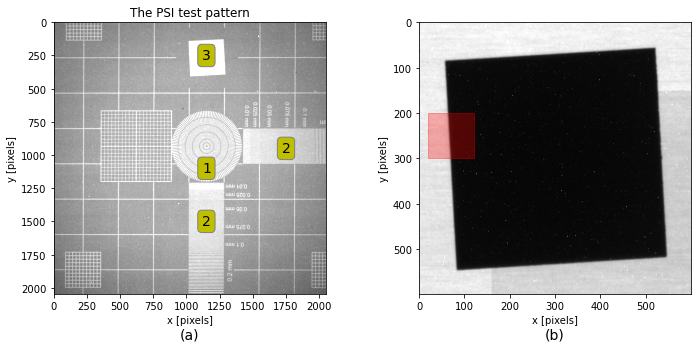

In [18]:
fig,ax = plt.subplots(1,2,figsize=(12,5))
img1 = tiff.imread('../00_common/data/edges/edge20mm_0000.tif')

idx_edge    = 1
idx_pattern = 0
ax[idx_edge].imshow(img1,vmin=300,vmax=30000,cmap='gray');
ax[idx_edge].set_xlabel('x [pixels]')
ax[idx_edge].set_ylabel('y [pixels]');
rect=mpatches.Rectangle((20,200),100,100,fc='r',ec='r',alpha=0.3)
ax[idx_edge].add_patch(rect)

img2 = fits.getdata('data/focus_34mm_60s.fits')
ax[idx_pattern].imshow(img2,vmin=800,vmax=10000,cmap='gray')
ax[idx_pattern].set_title('The PSI test pattern')
bbox_props = dict(boxstyle="round", fc="y", ec="0.5", alpha=1.0)
ax[idx_pattern].text(1150,1100, "1", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,1500, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1750,950, "2", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].text(1150,250, "3", ha="center", va="center", size=14,
        bbox=bbox_props)
ax[idx_pattern].set_xlabel('x [pixels]')
ax[idx_pattern].set_ylabel('y [pixels]');

fontsize=14
labelposition= -0.15
# Set label for panel 1 -> (a)
ax[0].text(0.5, labelposition, '(a)', transform=ax[0].transAxes, fontsize=fontsize, ha='center',va='center')  


# Set label for panel 2 -> (b)
ax[1].text(0.5, labelposition, '(b)', transform=ax[1].transAxes, fontsize=fontsize, ha='center',va='center') ; 

The figure above shows two devices that can be used to measure the resolution. Panel (a) shows a segment of a test pattern device with different features to measure the resolution. 
1. Siemens star. The spatial frequeny of the spokes in decrease as function of the radius. 
2. Line patterns. Blocks of parallel line with given spatial frequency.
3. Straight absorbing edges.

The item in panel (b) is an absorbing item with straight edges.

## Measuring the resolution using test patterns

## Measuring the resolution using edge spread

In [19]:
### Extracting the edge profile

## Summary